In [1]:
import matplotlib
matplotlib.use("Agg")

In [2]:
import matplotlib.pyplot as plt
from mozaik.storage.datastore import PickledDataStore
from parameters import ParameterSet
from mozaik.storage.queries import *
import sys
%matplotlib inline
import logging
import scipy
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [3]:
from mozaik.analysis.analysis import Analysis
from mozaik.analysis.data_structures import SingleValue, AnalogSignal
from mozaik.analysis.technical import NeuronAnnotationsToPerNeuronValues
import numpy as np
import mozaik.tools.units as munits
from neo.core.analogsignal import AnalogSignal as NeoAnalogSignal
import quantities as qt
from mozaik.storage import queries

class RecordingArrayAnalysis(Analysis):

    required_parameters = ParameterSet(
        {
            "s_res": int,  # Space resolution (bin size in um) of orientation map
            "array_width": float, # Electrode array width (um)
        }
    )
    
    def electrode_positions(self, array_width, s_res):
        assert array_width % s_res == 0
        row_electrodes = int(array_width / s_res)

        electrode_pos = np.linspace(
            s_res / 2, array_width - s_res / 2, row_electrodes
        )
        electrode_x, electrode_y = np.meshgrid(electrode_pos, electrode_pos)
        electrode_x, electrode_y = electrode_x.flatten(), electrode_y.flatten()
        return electrode_x - array_width / 2, electrode_y - array_width / 2

    def get_st_ids(self,dsv):
        assert len(dsv.sheets()) == 1, "Analysis needs to be run on a single sheet!"
        return [s for s in dsv.get_segments() if len(s.spiketrains) > 0][0].get_stored_spike_train_ids()

    def get_s(self, dsv, s_res=None, neuron_ids=None):
        if s_res == None:
            s_res = 1
        if neuron_ids is None:
            neuron_ids = self.get_st_ids(dsv)
        sheet = dsv.sheets()[0]
        pos = dsv.get_neuron_positions()[sheet]
        posx = np.round((pos[0, dsv.get_sheet_indexes(sheet, neuron_ids)] / s_res * 1000)).astype(int)
        posy = np.round((pos[1, dsv.get_sheet_indexes(sheet, neuron_ids)] / s_res * 1000)).astype(int)
        return posx, posy

    def neuron_electrode_dists(self, x, y, electrode_x, electrode_y):
        # Returns distance matrix (neurons x electrodes)
        neuron_x, neuron_y = (
            np.tile(x, (len(electrode_x), 1)).T,
            np.tile(y, (len(electrode_y), 1)).T,
        )
        electrode_x, electrode_y = np.tile(electrode_x, (len(x), 1)), np.tile(
            electrode_y, (len(y), 1)
        )
        return np.sqrt((electrode_x - neuron_x) ** 2 + (electrode_y - neuron_y) ** 2)
    
    def perform_analysis(self):
        self.tags.extend(["s_res: %d" % self.parameters.s_res,"array_width: %d" % self.parameters.array_width])

class RecordingArrayOrientationMap(RecordingArrayAnalysis):

    def gen_or_map(self, dsv, s_res, array_width):
        x, y = self.get_s(dsv)
        electrode_x, electrode_y = self.electrode_positions(array_width, s_res)
        d = self.neuron_electrode_dists(x, y, electrode_x, electrode_y)
        analysis_result = dsv.full_datastore.get_analysis_result(
            identifier="PerNeuronValue",
            value_name="LGNAfferentOrientation",
        )
        if len(analysis_result) == 0:
            NeuronAnnotationsToPerNeuronValues(dsv, ParameterSet({})).analyse()
        result = dsv.full_datastore.get_analysis_result(
            identifier="PerNeuronValue",
            value_name="LGNAfferentOrientation",
        )[0]
        st_ids = [s for s in dsv.get_segments() if len(s.spiketrains) > 0][
            0
        ].get_stored_spike_train_ids()
        orientations = np.array(result.get_value_by_id(st_ids))

        closest_neuron_idx = np.argmin(d,axis=0)#.astype(int)
        or_map_orientations = orientations[closest_neuron_idx]
        square_side = int(np.sqrt(len(or_map_orientations)))
        return or_map_orientations.reshape(square_side,square_side)

    def perform_analysis(self):
        super().perform_analysis()
        for sheet in self.datastore.sheets():
            dsv = queries.param_filter_query(self.datastore, sheet_name=sheet)
            or_map = self.gen_or_map(dsv, self.parameters.s_res, self.parameters.array_width)  
            self.datastore.full_datastore.add_analysis_result(
                SingleValue(
                    value=or_map,
                    value_units=qt.radians,
                    value_name="orientation map",
                    tags=self.tags,
                    sheet_name=self.datastore.sheets()[0],
                    analysis_algorithm=self.__class__.__name__,
                )
            )
    
class RecordingArrayTimecourse(RecordingArrayAnalysis):
    
    required_parameters = ParameterSet(
        {
            "t_res": int,  # Time resolution (bin size in ms) of activity maps
            "s_res": int,  # Space resolution (bin size in um) of activity maps
            "array_width": float, # Electrode array width (um)
            "electrode_radius": float, # Electrode radius (um)
        }
    )
    
    def get_t(self, seg, t_res=None):
        if t_res == None:
            t_res = 1
        return [list((st.magnitude / t_res).astype(int)) for st in seg.get_spiketrains()]
    
    def neuron_spike_array(self, t, stim_len):
        s = np.zeros((len(t), int(stim_len)))
        for i in range(len(t)):
            for j in range(len(t[i])):
                if t[i][j] < stim_len:
                    s[i, t[i][j]] += 1
        return s

    def get_electrode_recordings(self, s, d, radius):
        # The recordings are a mean of all activity in the electrode radius
        rec = np.zeros((d.shape[1], s.shape[1]))
        for i in range(d.shape[1]):
            rec[i, :] += s[d[:, i] < radius, :].mean(axis=0)
        rec = rec.reshape(int(np.sqrt(d.shape[1])), int(np.sqrt(d.shape[1])), -1)
        return rec
    
    def perform_analysis(self):
        super().perform_analysis()
        self.tags.extend(["t_res: %d" % self.parameters.t_res, "electrode_radius: %d" % self.parameters.electrode_radius])
        for sheet in self.datastore.sheets():
            dsv = queries.param_filter_query(self.datastore, sheet_name=sheet)
            x, y = self.get_s(dsv)
            segs, stims = dsv.get_segments(), dsv.get_stimuli()
            for i in range(len(segs)):
                if len(segs[i].spiketrains) < 1:
                    continue
                t = self.get_t(segs[i], t_res=self.parameters.t_res)
                stim_len = ParameterSet(str(stims[i]).replace("MozaikExtended",""))["duration"] // self.parameters.t_res
                electrode_x, electrode_y = self.electrode_positions(self.parameters.array_width, self.parameters.s_res)
                d = self.neuron_electrode_dists(x, y, electrode_x, electrode_y)
                s = self.neuron_spike_array(t, stim_len)
                electrode_recordings = np.nan_to_num(self.get_electrode_recordings(s / self.parameters.t_res * 1000, d, self.parameters.electrode_radius))
                electrode_recordings = electrode_recordings.transpose((2,0,1)) # Time should be first dimension
                self.datastore.full_datastore.add_analysis_result(
                    AnalogSignal(
                        NeoAnalogSignal(electrode_recordings, t_start=0, sampling_period=self.parameters.t_res*qt.ms,units=munits.spike / qt.s),
                        y_axis_units=munits.spike / qt.s,
                        tags=self.tags,
                        sheet_name=sheet,
                        stimulus_id=str(stims[i]),
                        analysis_algorithm=self.__class__.__name__,
                    )
                )

In [4]:
if 0:
    path = "/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250120-213934[param_spont.defaults]CombinationParamSearch{trial:[0]}/SelfSustainedPushPull_ParameterSearch_____trial:0"
    data_store = PickledDataStore(
            load=True,
            parameters=ParameterSet({"root_directory": path, "store_stimuli": False}),
            replace=False,
    )
    RecordingArrayOrientationMap(param_filter_query(data_store,sheet_name=["V1_Exc_L2/3"]),
    ParameterSet(
        {
            "s_res": 40, 
            "array_width": 4000,
        }
    ),  
    ).analyse()

if 0:
    or_map = queries.param_filter_query(data_store,analysis_algorithm="RecordingArrayOrientationMap").get_analysis_result()[0].value
    print(or_map.shape)
    plt.imshow(or_map,cmap='hsv')
    plt.show()

In [5]:
import os
def get_full_datastore_paths(base_paths):
    """
    Get unique subdirectory paths across multiple base directories, keeping first occurrence.
    
    Args:
        base_paths: A single base path string or a list of base path strings
        
    Returns:
        List of unique subdirectory paths that match the criteria
    """
    if isinstance(base_paths, str):
        base_paths = [base_paths]
    
    seen_paths = set()
    result = []
    
    for base_path in base_paths:
        full_base_path = os.path.join(base_dir, base_path)
        if not os.path.isdir(full_base_path):
            continue
            
        for path in os.listdir(full_base_path):
            full_path = os.path.join(full_base_path, path)
            if os.path.isdir(full_path):
                if path not in seen_paths:
                    seen_paths.add(path)
                    result.append(full_path)
                continue  # No need to check other coords for this path
    return [result[idx] for idx in np.argsort([int(p.split(":")[-1]) for p in result])]

base_dir = "/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/"
m1_base_paths = ['20250310-190155[param_spont.defaults]CombinationParamSearch{trial:6}','20250401-160252[param_spont.defaults]CombinationParamSearch{trial:6}']
m2_base_paths = ['20250310-190201[param_spont.defaults]CombinationParamSearch{trial:6}','20250401-160316[param_spont.defaults]CombinationParamSearch{trial:6}']
no_m_base_paths = ['20250317-112256[param_spont.defaults]CombinationParamSearch{trial:6}','20250401-160323[param_spont.defaults]CombinationParamSearch{trial:6}']
#m1_base_path = 
#m2_base_path = 
coords = np.array([int(p.split(":")[-1]) for p in get_full_datastore_paths(m1_base_paths)])
#get_full_datastore_paths = lambda base_path : [os.path.join(base_dir,base_path,path) for coord in coords for path in os.listdir(os.path.join(base_dir,base_path)) if os.path.isdir(os.path.join(base_dir,base_path,path)) and f"trial:{coord}" in path]
get_datastores = lambda paths : [PickledDataStore(load=True,parameters=ParameterSet({"root_directory": path, "store_stimuli": False}),replace=False) for path in paths]

ds_2_dot = {}
ds_2_dot["morph_1"] = get_datastores(get_full_datastore_paths(m1_base_paths))
ds_2_dot["morph_2"] = get_datastores(get_full_datastore_paths(m2_base_paths))
ds_2_dot["no_morph"] = get_datastores(get_full_datastore_paths(no_m_base_paths))
t_res, s_res, array_width = 5, 50, 4000

In [88]:
for name in ds_2_dot.keys():
    print(name)
    for i in range(len(ds_2_dot[name])):
        print(f"Distance {i*100} um")
        ds_2_dot[name][i].remove_ads_from_datastore()
        RecordingArrayTimecourse(param_filter_query(ds_2_dot[name][i],sheet_name="V1_Exc_L2/3"),
            ParameterSet(
                {
                    "s_res": s_res,
                    "t_res": t_res,
                    "array_width": 3950,
                    "electrode_radius": 50,
                }
            ),
        ).analyse()
    #ds.save()

morph_1
Distance 0 um
INFO:Mozaik:Starting RecordingArrayTimecourse analysis
Distance 100 um
INFO:Mozaik:Starting RecordingArrayTimecourse analysis
Distance 200 um
INFO:Mozaik:Starting RecordingArrayTimecourse analysis
Distance 300 um
INFO:Mozaik:Starting RecordingArrayTimecourse analysis
Distance 500 um
INFO:Mozaik:Starting RecordingArrayTimecourse analysis
Distance 600 um
INFO:Mozaik:Starting RecordingArrayTimecourse analysis
Distance 700 um
INFO:Mozaik:Starting RecordingArrayTimecourse analysis
Distance 800 um
INFO:Mozaik:Starting RecordingArrayTimecourse analysis
Distance 900 um
INFO:Mozaik:Starting RecordingArrayTimecourse analysis
morph_2
Distance 0 um
INFO:Mozaik:Starting RecordingArrayTimecourse analysis
Distance 100 um
INFO:Mozaik:Starting RecordingArrayTimecourse analysis
Distance 200 um
INFO:Mozaik:Starting RecordingArrayTimecourse analysis
Distance 300 um
INFO:Mozaik:Starting RecordingArrayTimecourse analysis
Distance 400 um
INFO:Mozaik:Starting RecordingArrayTimecourse ana

In [6]:
ds_2_dot_current = {}
ds_2_dot_current["morph_1"] = get_datastores(get_full_datastore_paths(['20250728-144432[param_spont.defaults]CombinationParamSearch{12}']))
ds_2_dot_current["morph_2"] = get_datastores(get_full_datastore_paths(['20250728-144438[param_spont.defaults]CombinationParamSearch{12}']))
ds_2_dot_current["no_morph"] = get_datastores(get_full_datastore_paths(['20250728-144444[param_spont.defaults]CombinationParamSearch{12}']))

In [81]:
def gaussian_smooth(x, y, x_eval, sigma):
    """Smooth y values at x_eval using Gaussian kernel smoothing."""
    smoothed_mean = np.zeros_like(x_eval)
    smoothed_se = np.zeros_like(x_eval)

    for i, xe in enumerate(x_eval):
        weights = scipy.stats.norm.pdf(x, loc=xe, scale=sigma)  # Gaussian weights
        weights /= weights.sum()  # Normalize weights
        smoothed_mean[i] = np.sum(weights * y)
        smoothed_se[i] = np.sqrt(np.sum(weights * (y - smoothed_mean[i])**2)) / np.sqrt(weights.sum())
    
    return smoothed_mean, smoothed_se

def get_current_profiles(dsv, r_fine):
    ids = dsv.get_analysis_result()[0].ids
    A = np.array(dsv.get_analysis_result()[0].asl).squeeze()
    pos = dsv.get_neuron_positions()["V1_Exc_L2/3"][:2,dsv.get_sheet_indexes("V1_Exc_L2/3", ids)]
    subselection = np.abs(pos[1, :]) < 0.025
    #subselection = np.logical_and(pos[1, :] > 0, pos[1, :] < 0.05)
    pos = pos[:,subselection]
    A = A[subselection,:]
    xpos = pos[0,:]
    sort_idx = np.argsort(xpos)
    return np.array([gaussian_smooth(xpos[sort_idx], A[:,i][sort_idx], r_fine, 0.005) for i in range(A.shape[1])])

r_fine = np.linspace(-0.5, 1, 900)  # Fine grid for smoothness
I_m1 = np.array([get_current_profiles(param_filter_query(ds.full_datastore,y_axis_name='optical_stimulation_current'),r_fine) for ds in ds_2_dot_current["morph_1"] ])
I_m2 = np.array([get_current_profiles(param_filter_query(ds.full_datastore,y_axis_name='optical_stimulation_current'),r_fine) for ds in ds_2_dot_current["morph_2"] ])
I_no_morph = np.array([get_current_profiles(param_filter_query(ds.full_datastore,y_axis_name='optical_stimulation_current'),r_fine) for ds in ds_2_dot_current["no_morph"]])

/tmp/ipykernel_95912/686040981.py:8: RuntimeWarning: invalid value encountered in divide
  weights /= weights.sum()  # Normalize weights


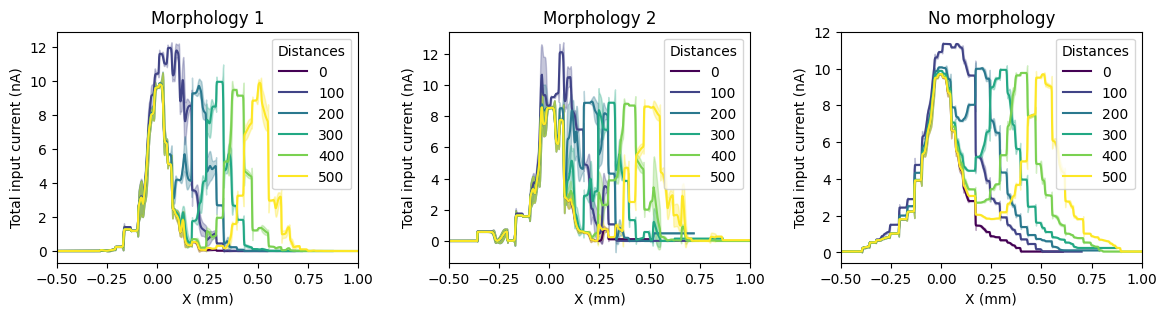

In [82]:
def plot_I(I,ax,title=""):
    colors = [plt.get_cmap("viridis")(i / (len(distances) - 1)) for i in range(len(distances))]
    for i in range(len(distances)):
        I_mean, I_sem = I[i,:,0,:].sum(axis=0), I[i,:,1,:].sum(axis=0)
        ax.plot(r_fine,I_mean,color=colors[i])
        ax.fill_between(r_fine, I_mean - I_sem, I_mean + I_sem, 
                         alpha=0.3, label="_nolegend_",color=colors[i])
    ax.set_title(title)
    ax.set_xlabel("X (mm)")
    ax.set_ylabel("Total input current (nA)")
    ax.set_xlim(-0.5,1)
    ax.legend(labels=distances,title="Distances")

distances = [0,100,200,300,400,500]
fig,ax = plt.subplots(1,3,figsize=(14,3))
plt.subplots_adjust(wspace=0.3)
plot_I(I_m1,ax[0],"Morphology 1")
plot_I(I_m2,ax[1],"Morphology 2")
plot_I(I_no_morph,ax[2],"No morphology")
plt.show()

In [83]:
print(I_m1.shape)

(6, 150, 2, 900)


In [84]:
np.save("dual_stim_current_mean.npy",np.stack([I_m1[:,:,0,:],I_m2[:,:,0,:],I_no_morph[:,:,0,:]]))
np.save("dual_stim_current_sem.npy",np.stack([I_m1[:,:,1,:],I_m2[:,:,1,:],I_no_morph[:,:,1,:]]))

In [89]:
n_trials= 30
data_2_dot = {k: {} for k in ds_2_dot.keys()}
for key in data_2_dot.keys():
    data_2_dot[key]["A"] = np.array([[np.array(param_filter_query(ds.full_datastore,st_trial=j,st_name='InternalStimulus',analysis_algorithm='RecordingArrayTimecourse').get_analysis_result()[0].analog_signal) for j in range(n_trials)] for ds in ds_2_dot[key]])
    #print(data_2_dot[key]["A"].shape)
    data_2_dot[key]["mean"] = data_2_dot[key]["A"][:100 // t_res].mean(axis=(1,2))
    #data_2_dot[key]["sem"] = data_2_dot[key]["A"][:100 // t_res].mean(axis=2).std(axis=(1)) / np.sqrt(n_trials)
    data_2_dot[key]["sem"] = (data_2_dot[key]["A"][:100 // t_res].std(axis=(1)) / np.sqrt(n_trials)).mean(axis=1)

In [111]:
np.save("dual_stim_mean.npy",np.stack([data_2_dot["morph_1"]["mean"],data_2_dot["morph_2"]["mean"],data_2_dot["no_morph"]["mean"]])[:,:,39,:])
np.save("dual_stim_sem.npy",np.stack([data_2_dot["morph_1"]["sem"],data_2_dot["morph_2"]["sem"],data_2_dot["no_morph"]["sem"]])[:,:,39,:])

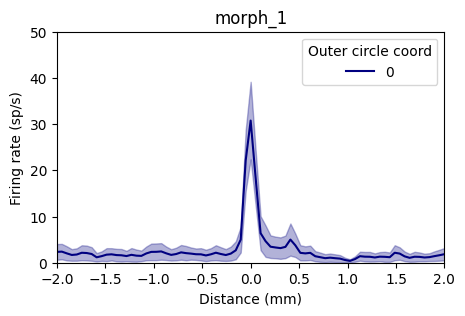

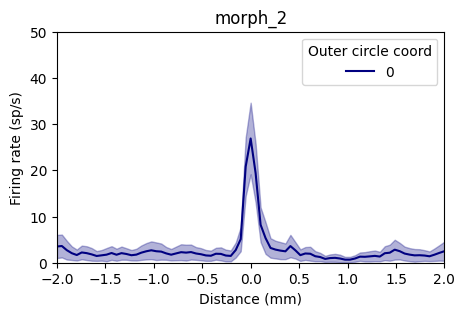

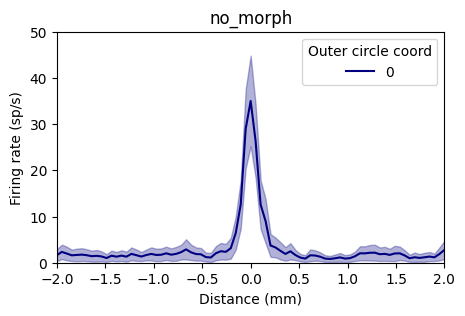

In [95]:
for key in data_2_dot.keys():
    plt.figure(figsize=(5,3))
    colors = [plt.get_cmap("jet")(i / (len(coords) - 1)) for i in range(len(coords))]
    for i in range(1):#len(coords)):
        x = np.linspace(-2,2,data_2_dot[key]["mean"].shape[-1])
        mean, sem = data_2_dot[key]["mean"][i,39,:], data_2_dot[key]["sem"][i,39,:]
        plt.fill_between(x, mean - sem, mean + sem, 
                 alpha=0.3, label="_nolegend_",color=colors[i])
        plt.plot(x,mean,color=colors[i])
    plt.title(key)
    plt.ylim(0,50)
    plt.xlim(-2,2)
    plt.xlabel("Distance (mm)")
    plt.ylabel("Firing rate (sp/s)")
    plt.legend(coords,title="Outer circle coord")
    plt.show()

In [96]:
dual_stim_mean_load = np.load("dual_stim_mean.npy")
dual_stim_sem_load = np.load("dual_stim_sem.npy")

In [98]:
print(dual_stim_mean_load.shape)
print(data_2_dot[key]["mean"].shape)

(3, 10, 80)
(10, 79, 79)


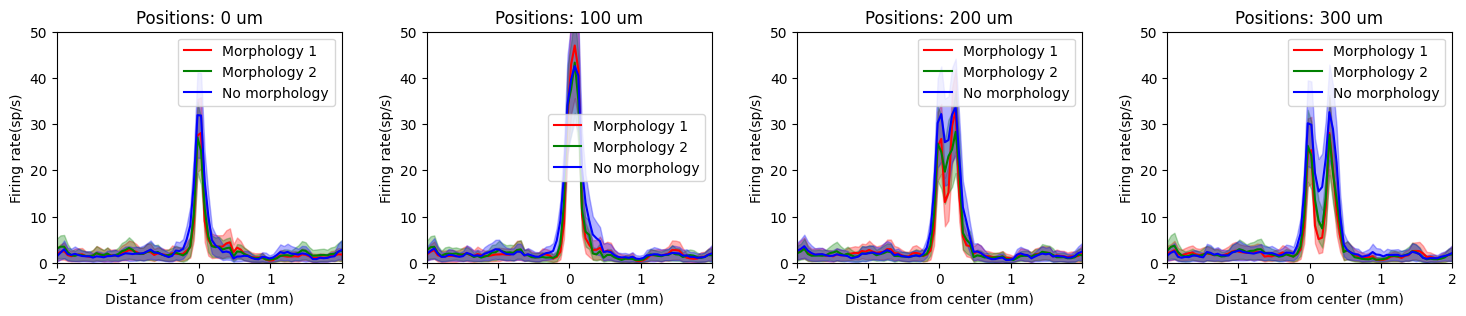

In [158]:
def plot_fr_across_morphs(data_dict,positions=[0,300,600,900,1200,1500]):
    fig,ax = plt.subplots(1,len(positions),figsize=(2+4*len(positions),3))
    plt.subplots_adjust(wspace=0.3)
    x = np.linspace(-2, 2, array_width // s_res)
    names = list(data_dict.keys())
    colors = ["r","g","b"]
    for i in range(len(positions)):
        for j in range(len(names)):
            mean, sem = data_dict[names[j]]["mean"][i,40,:], data_dict[names[j]]["sem"][i,40,:]
            ax[i].plot(x,mean,color=colors[j])
            ax[i].fill_between(x, mean - sem, mean + sem, 
                             alpha=0.3, label="_nolegend_",color=colors[j])
        ax[i].legend(labels=["Morphology 1","Morphology 2","No morphology"])
        ax[i].set_title(f"Positions: {positions[i]} um")
        ax[i].set_xlabel("Distance from center (mm)")
        ax[i].set_ylabel("Firing rate(sp/s)")
        ax[i].set_xlim(-2,2)
        ax[i].set_ylim(0,50)
    plt.show()

#plot_fr_across_morphs(data_2_dot,positions=coords)
plot_fr_across_morphs(data_2_dot,positions=[0,100,200,300])

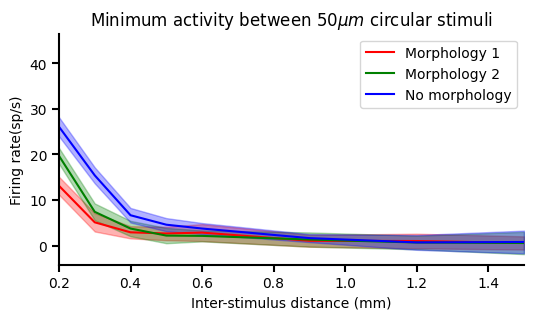

[[42.93333333 13.13131313  5.11111111  2.92063492  2.66666667  2.86111111
   1.06349206  1.01010101  0.58585859]
 [37.62222222 19.6969697   7.41269841  3.74603175  2.20634921  2.13888889
   1.33333333  0.68253968  0.57777778]
 [39.71111111 26.08080808 15.41414141  6.66666667  4.59259259  3.75
   1.65079365  0.7037037   0.8       ]]


In [163]:
start = 40
ends = np.array([40+int((coords[i])/s_res)-1 for i in range(1,data_2_dot["morph_1"]["mean"].shape[0])])
mins = np.array([[np.min(data_2_dot[key]["mean"][i+1,40,start:ends[i]]) for i in range(len(ends))]for key in data_2_dot.keys()])
sems = np.array([[data_2_dot[key]["sem"][i+1,40,np.argmin(data_2_dot[key]["mean"][i+1,40,start:ends[i]])] for i in range(len(ends))]for key in data_2_dot.keys()])
plt.figure(figsize=(6,3))
for i,c in zip(range(3),['r','g','b']):
    plt.plot(np.array(coords[1:])/1000,mins[i,:],color=c)
    plt.fill_between(np.array(coords[1:])/1000, mins[i,:] - sems[i,:], mins[i,:] + sems[i,:], alpha=0.3, label="_nolegend_",color=c)
plt.xlim(0.2,1.5)
plt.title("Minimum activity between 50$\\mu m$ circular stimuli")
plt.xlabel("Inter-stimulus distance (mm)")
plt.ylabel("Firing rate(sp/s)")
plt.gca().spines[['top','right']].set_visible(False)
plt.gca().spines[['left','bottom']].set_linewidth(1.5)
plt.gca().tick_params(size=5, width=1.5)
plt.legend(labels=["Morphology 1","Morphology 2","No morphology"])
plt.show()
print(mins)

In [140]:
print(repr(mins[:,1:]))
print(repr(sems[:,1:]))
print(repr(coords[2:]))

array([[13.13131313,  5.11111111,  2.92063492,  2.66666667,  2.86111111,
         1.06349206,  1.01010101,  0.58585859],
       [19.6969697 ,  7.41269841,  3.74603175,  2.20634921,  2.13888889,
         1.33333333,  0.68253968,  0.57777778],
       [26.08080808, 15.41414141,  6.66666667,  4.59259259,  3.75      ,
         1.65079365,  0.7037037 ,  0.8       ]])
array([[2.85470085, 2.71604938, 1.7962963 , 1.94444444, 2.34567901,
        1.71428571, 2.04761905, 1.95238095],
       [2.41025641, 2.33333333, 2.16666667, 2.22222222, 1.45679012,
        1.97530864, 1.85858586, 3.24444444],
       [2.97435897, 2.49382716, 2.35185185, 1.82222222, 1.60493827,
        1.17948718, 2.3030303 , 3.22222222]])
array([ 200,  300,  400,  500,  600,  900, 1200, 1500])


2050 1500


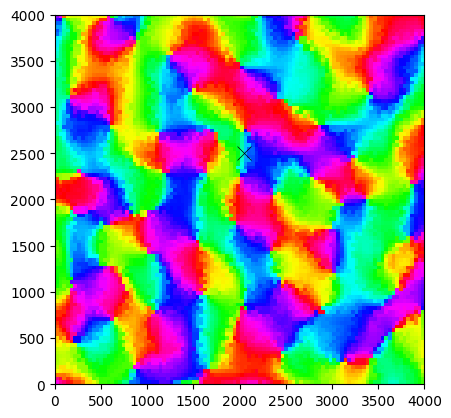

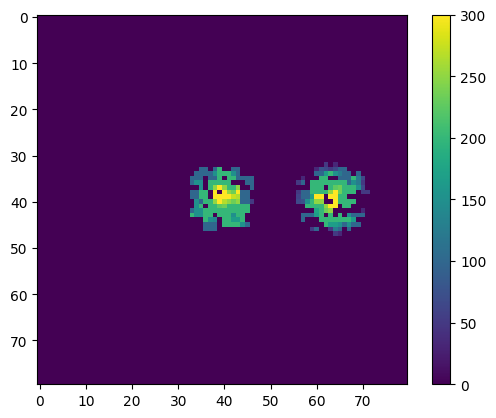

(15, 80, 80)


In [63]:
plt.imshow(or_map,cmap='hsv',interpolation='none',extent=(0,4000,0,4000))
#x,y = 350,-40 # Pinwheel
x,y = 50,-500 # edge
#x,y = 300,0 # Test
#x,y = 2000, 2000 # Center
x_,y_ = x + 2000, y  + 2000 
print(x_,y_)
plt.scatter(x_,4000-y_,s=100,c='k',marker='x',lw=0.5)
plt.show()

plt.imshow(A[3,:,:])
plt.colorbar()
plt.show()
print(A.shape)